## Author: Igor Dzierwa
## Laboratory 3 - Implementation of Gradient Descent in neural networks with one hidden layer

In this lab we are going to implement a neural network with one hidden layer. The architecture of our neural network is as follows:

- Input layer with 3 neurons
- One hidden layer with 2 neurons
- Output layer with 1 neuron

The dataset has 200 data each one has three features selected from a random normal distribution with a mean of zero and the standard deviation of 5 and the actual labels 0 or 1.

Weights are also initialized randomly from normal distribution with *Xavier* initialization technique. 

Hidden  layer activation is *Tanh* and the output layer activation is *Sigmoid* with *binary cross-entropy* as loss.

Also, for this task use batch gradient descent algorithm.

Please define different functions for each part of the training process:
- initialization
- activation functions and their derivative 
- loss function and its derivative 
- forward propagation
- backpropagation 
- parameters update
- training

```Python
learning rate = 0.001
```

### Libraries import

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Data initialization

**Features** - selected from a random normal distribution with a mean of zero and the standard deviation of 5.

**Ouput**  - there are implemented two possibilites:
- selected random integer 0 or 1 *(without threshold)*.
- calculation based on the features. If the sum of them is greater or egual 0 - the label is equal to 1, otherwise the label is eaual to 0 *(with threshold)*.

In [2]:
def dataset_initialization(mean=0, sd=5, count=200, features=3, threshold=False, separate=False):
    features = np.random.normal(mean, sd, size=(count, features))
    
    if threshold:
        output = np.array([[1.0] if np.sum(i) >= 0 else [0.0] for i in features])
    else:
        output = np.array([[float(random.randint(0,1))] for i in features])
    
    if separate:
        return features, output
    
    return np.concatenate((features, output), axis=1)

### Tanh activation function (hidden layer)
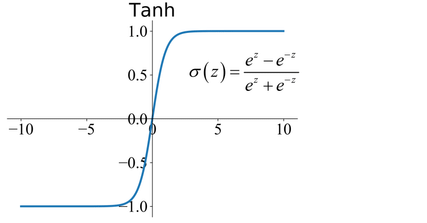

In [3]:
def tanh(x):
    return np.tanh(x)

### Sigmoid activation function (output layer)
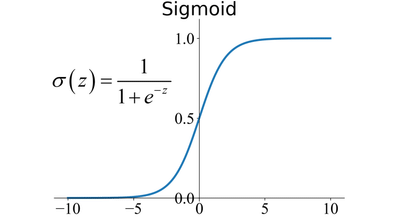

In [4]:
def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

### Cross entropy loss function
**Binary cross-entropy** is often calculated as the average cross-entropy across all data examples:

$$ L = -{1\over N} \left[\sum_{j=1}^{N}\left[t_{j}\log(p_{j}) + (1-t_{j})\log(1-p_{j})\right]\right]$$

In [66]:
def cross_entropy_cost(self, prediction, output):
    m = output.shape[1] # number of training example

    log_prob = np.multiply(np.log(prediction), output) + np.multiply((1-output), np.log(1 - prediction))
    cost = - np.sum(log_prob) / m
    cost = float(np.squeeze(cost))

    return cost

### Xavier initialization technique

Approach is based on multiplying random initialization with the following scaling factor for the weights:

$$ {\sqrt{1} \over n} $$

In [6]:
mean = 0
sd = 5
hidden_neurons_count = 2
features_count = 3

np.random.normal(mean, sd, size=(hidden_neurons_count, features_count)) * np.sqrt(1 / features_count)

array([[-1.23157779, -0.69665172, -0.46444504],
       [-6.07969861, -1.02983306, -2.25812846]])

### Neural Network implementation

In [27]:
class NeuralNetwork():
    def __init__(self, input_unit, hidden_unit, output_unit, learning_rate):        
        self.input_unit = input_unit
        self.hidden_unit = hidden_unit
        self.output_unit = output_unit
        
        self.learning_rate = learning_rate
    
    def weights_biases_init(self, mean, sd):
        weights_1 = np.random.normal(mean, sd, size=(self.hidden_unit, self.input_unit))
        self.weights_1 = weights_1 * np.sqrt(1 / self.input_unit)
        self.bias_1 = np.zeros((self.hidden_unit, 1))

        weights_2 = np.random.normal(mean, sd, size=(self.output_unit, self.hidden_unit))
        self.weights_2 =  weights_2 * np.sqrt(1 / self.input_unit)
        self.bias_2 = np.zeros((self.output_unit, 1))
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanah(self, x):
        return np.tanh(x)
    
    def tanah_deriv(self, x):
        a = self.tanah(x)
        return 1 - np.power(a, 2)
                
    def cross_entropy_cost(self, prediction, output):
        m = output.shape[1] # number of training example
        
        log_prob = np.multiply(np.log(prediction), output) + np.multiply((1-output), np.log(1 - prediction))
        cost = - np.sum(log_prob) / m
        cost = float(np.squeeze(cost))
                                    
        return cost
    
    def cross_entropy_cost_deriv(self, prediction, output):
        return prediction - output
    
    def gradient_descent(self, gradients):        
        self.weights_1 -= self.learning_rate * gradients['dW1']
        self.bias_1 -= self.learning_rate * gradients['db1']
        
        self.weights_2 -= self.learning_rate * gradients['dW2']
        self.bias_2 -= self.learning_rate * gradients['db2']
    
    def forward_propagation(self, inputs):
        z_1 = np.dot(self.weights_1, inputs) + self.bias_1
        a_1 = self.tanah(z_1)
        
        z_2 = np.dot(self.weights_2, a_1) + self.bias_2
        a_2 = self.sigmoid(z_2)
        
        cache = {"Z1": z_1,"A1": a_1, "Z2": z_2, "A2": a_2}
    
        return a_2, cache
    
    def backward_propagation(self, cache, inputs, output):
        m = inputs.shape[1] #number of training example

        A1 = cache['A1']
        A2 = cache['A2']

        dZ2 = self.cross_entropy_cost_deriv(A2, output)
        dW2 = (1/m) * np.dot(dZ2, A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True) # sum along the rows
        
        dZ1 = np.multiply(np.dot(self.weights_2.T, dZ2), self.tanah_deriv(A1))
        dW1 = (1/m) * np.dot(dZ1, inputs.T) 
        db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True) # sum along the rows

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

        return gradients
    
    def training(self, inputs, output, num_iterations = 1000):
        errors = []

        for i in range(0, num_iterations):
            prediction, cache = self.forward_propagation(inputs)
            cost = self.cross_entropy_cost(prediction, output)
            gradients = self.backward_propagation(cache, inputs, output)
            self.gradient_descent(gradients)
            
            if i % 10 == 0:
                errors.append(cost)
                
        return errors
    
    def predict(self, inputs):
        A2, cache = self.forward_propagation(inputs)
        predictions = np.round(A2)
    
        return predictions.flatten()
    
    def accuracy(self, inputs, output):
        predicted = self.predict(inputs)
        output = output.flatten()
        accuracy = np.sum(predicted == output) / len(output)
        return accuracy * 100

### Basic model training - dataset without defined threshold
**Features** - selected from a random normal distribution with a mean of zero and the standard deviation of 5.

**Output** - selected random integer 0 or 1.

In [42]:
data_x, data_y = dataset_initialization(mean=0, sd=5, count=200, features=3, threshold=False, separate=True)

print("Sample features:\n")
print(data_x[:5])

print("\nSample output:\n")
print(data_y[:5])

Sample features:

[[-5.84001707 -0.73024108  2.75624599]
 [-5.54943389  4.2127814   3.51349461]
 [-1.21191407 -1.53462561  9.702105  ]
 [ 4.06440458  3.11641171  4.83147927]
 [-3.90480308  3.83977883 -0.47024122]]

Sample output:

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]]


#### Data visualization

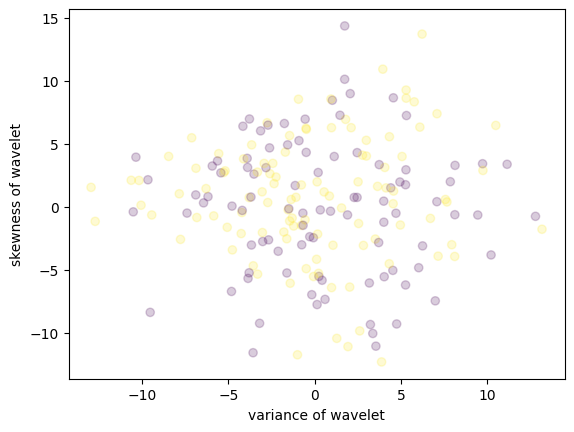

In [43]:
plt.scatter(data_x[:, 0], data_x[:, 1], alpha=0.2, c=data_y, cmap="viridis")
plt.xlabel("variance of wavelet")
plt.ylabel("skewness of wavelet");

#### Training Neutral Network

In [44]:
data_x = data_x.T
data_y = data_y.reshape(1, data_y.shape[0])

print ("X shape: ", data_x.shape)
print ("Y shape: ", data_y.shape)

X shape:  (3, 200)
Y shape:  (1, 200)


In [54]:
neural_network = NeuralNetwork(
    input_unit = data_x.shape[0], 
    hidden_unit = 2, 
    output_unit = data_y.shape[0], 
    learning_rate = 0.001
)

neural_network.weights_biases_init(mean=0, sd=5)

errors = neural_network.training(data_x, data_y, 10000)

#### Plot error for all training instances

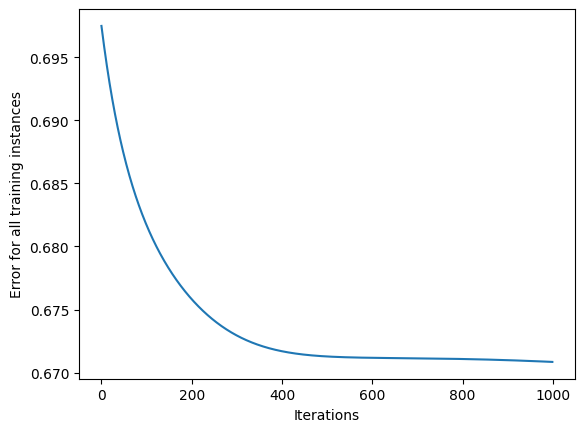

In [55]:
plt.plot(errors)
plt.xlabel("Iterations")
plt.ylabel("Error for all training instances")
plt.show()

#### Calculate accuracy

In [56]:
print(f"Accuracy: {neural_network.accuracy(data_x, data_y)}")

Accuracy: 56.99999999999999


### Model Training - dataset with defined threshold

**Features** - selected from a random normal distribution with a mean of zero and the standard deviation of 5.

**Output** - calculation based on the features. If the sum of them is greater or egual 0 the label is equal to 1, otherwise the label is eaual to 0.

In [57]:
data_x, data_y = dataset_initialization(mean=0, sd=5, count=200, features=3, threshold=True, separate=True)

print("Sample features:\n")
print(data_x[:5])

print("\nSample output:\n")
print(data_y[:5])

Sample features:

[[-4.04952588 -5.66655831 10.79057158]
 [ 0.13586355 -0.2455195  -1.55247233]
 [ 1.918538    0.83056283 -0.91727718]
 [-3.08045477  1.87462009  2.13987496]
 [-2.04129396  2.57638227  0.97934141]]

Sample output:

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]]


#### Data visualization

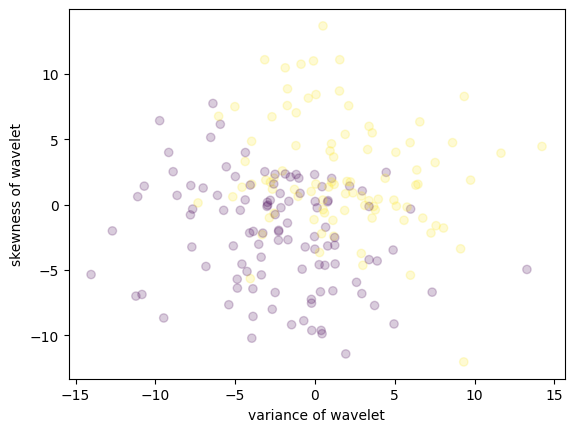

In [58]:
plt.scatter(data_x[:, 0], data_x[:, 1], alpha=0.2, c=data_y, cmap="viridis")
plt.xlabel("variance of wavelet")
plt.ylabel("skewness of wavelet");

#### Split data to training and test set

In [59]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

#### Training Neutral Network

In [60]:
x_train = x_train.T
x_test = x_test.T

y_train = y_train.reshape(1, y_train.shape[0])
y_test = y_test.reshape(1, y_test.shape[0])


print ("Train x shape: ", x_train.shape)
print ("Train y shape: ", y_train.shape)

print ("\nTest x shape: ", x_test.shape)
print ("Test y shape: ", y_test.shape)

Train x shape:  (3, 160)
Train y shape:  (1, 160)

Test x shape:  (3, 40)
Test y shape:  (1, 40)


In [61]:
neural_network = NeuralNetwork(
    input_unit = x_train.shape[0], 
    hidden_unit = 2, 
    output_unit = y_train.shape[0], 
    learning_rate = 0.001
)

neural_network.weights_biases_init(mean=0, sd=5)

errors = neural_network.training(x_train, y_train, 5000)

#### Plot error for all training instances

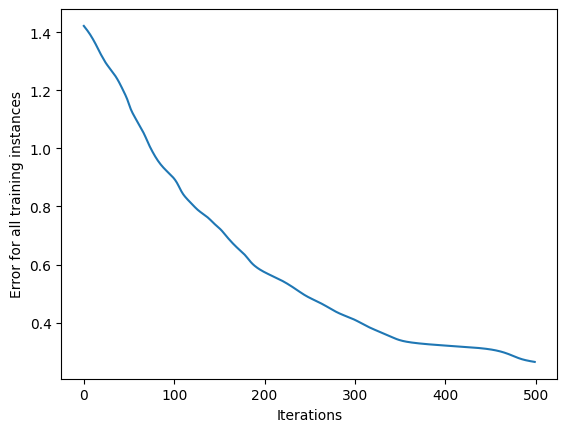

In [62]:
plt.plot(errors)
plt.xlabel("Iterations")
plt.ylabel("Error for all training instances")
plt.show()

#### Calculate accuracy

In [63]:
print(f"Accuracy Train: {neural_network.accuracy(x_train, y_train)}")
print(f"\nAccuracy Test: {neural_network.accuracy(x_test, y_test)}")

Accuracy Train: 91.875

Accuracy Test: 97.5
